In [1]:
# Install a pip package in the current Jupyter kernel
import sys
!{sys.executable} -m pip install numpy pandas matplotlib numpy_ringbuffer sklearn

import pickle
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from strategy import Strategy
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

/usr/local/lib/python3.7/site-packages/pandas/plotting/_converter.py:129: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


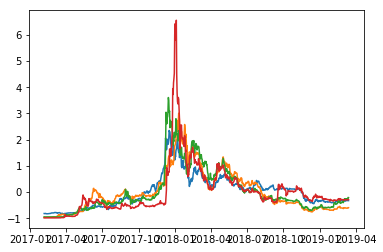

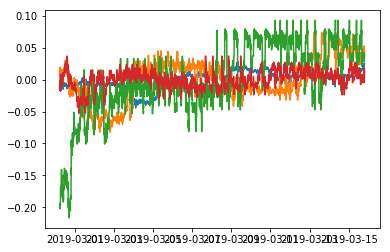

In [2]:
currencies = ['usd', 'btc', 'eth', 'ltc', 'xrp', 'eos']
pairs = [c + '_usd' for c in currencies if c != 'usd']
volume_keys = [c + '_tx_volume' for c in currencies if c != 'usd']

def prep_data(file):
    data = pickle.load(open(file, 'rb'))
    dates = [x['date'] for x in data]
    prices = [{k:v for k,v in x.items() if k in pairs} for x in data]
    volumes = [{(k.partition('_')[0] + '_usd'):v for k,v in x.items() if k in volume_keys} for x in data]
    return {
        'prices': pd.DataFrame(prices, index = dates),
        'volumes': pd.DataFrame(volumes, index = dates)
    }

def reduce_data(data, resampling):
    '''Averages prices, sums volumes'''
    prices = data['prices'].resample(resampling).first().fillna(method='ffill')
    volumes = data['volumes'].resample(resampling).sum().fillna(method='ffill')
    return { 'prices': prices, 'volumes': volumes }

def tail_data(data, n):
    '''get the last n points of the given data'''
    prices = data['prices'].tail(n)
    volumes = data['volumes'].tail(n)
    return { 'prices': prices, 'volumes': volumes }

def viz_data(data):
    '''Only plots prices for now'''
    plt.plot(data['prices'] / data['prices'].mean() - 1)
    plt.show()

def data_currencies(data):
    currencies = ['usd']
    for pair in data['prices'].columns:
        currencies.append(pair.partition('_')[0])
    return currencies

def find_gaps(data, freq):
    idx_ref = pd.date_range(start=data.index[0], end=data.index[-1],freq=freq)
    gaps = idx_ref[~idx_ref.isin(data.index)]
    return gaps

data = prep_data('data.p')
viz_data(data)
data_min = reduce_data(prep_data('data-minute.p'), '1Min')
data_5min = reduce_data(data_min, '5Min')
data_15min = reduce_data(data_min, '15Min')
viz_data(data_min)

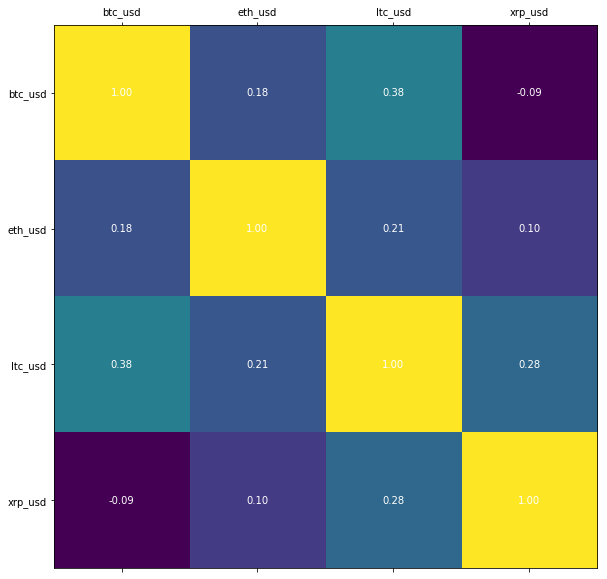

In [3]:
def plot_corr(df,size=10):
    '''Function plots a graphical correlation matrix for each pair of columns in the dataframe.

    Input:
        df: pandas DataFrame
        size: vertical and horizontal size of the plot'''

    corr = df['prices'].corr()
    fig, ax = plt.subplots(figsize=(size, size))
    ax.matshow(corr)
    plt.xticks(range(len(corr.columns)), corr.columns);
    plt.yticks(range(len(corr.columns)), corr.columns);
    # Loop over data dimensions and create text annotations.
    for i in range(len(corr.columns)):
        for j in range(len(corr.columns)):
            ax.text(j, i, '{:0.2f}'.format(corr.iloc[i, j]), ha="center", va="center", color="w")

plot_corr(data_15min)

In [4]:
def execute_orders(fees, prices, balances, orders):
    for (pair, size) in orders.items():
        # hacky...
        currency = pair.partition("_")[0]
        balances['usd'] -= size * prices[pair]
        balances[currency] += size

def pnl(balances, prices):
    usd = 0
    for (currency, qty) in balances.items():
        if currency == 'usd':
            usd += qty
        else:
            pair = currency + '_usd'
            usd += qty * prices[pair]
    return usd

def market_risk(pca, balances):
    '''Determines how much our P/L can change given 1-stddev movements along the pca components.
    sqrt(sum_pca(abs(sum_currency(position(currency)^2 * var(pc1) * pc1[currency]))))'''
    balances = pd.DataFrame([{(k+'_usd'):v for k,v in balances.items() if k != 'usd'}])
    components = pd.DataFrame(pca.components_, columns = data['prices'].columns)
    component_variances = components.mul(pca.explained_variance_, axis=0)
    pca_position_variances = component_variances.values.dot((balances * balances.abs()).values.T)
    risk = np.sqrt(np.abs(pca_position_variances).sum())
    return risk + 1e-10 # avoid div by 0

def evaluate(strategy, data, fees = 0):
    '''data is prices per-day
    TODO: separate hedger from strategy?'''
    balances = dict.fromkeys(data_currencies(data), 0)
    dates = []
    pnls = []
    balances_ = []
    balance_values = []
    risks = []
    price_diffs = data['prices'].diff().iloc[1:]
    diff_pca = PCA(n_components=0.997)
    diff_pca.fit(price_diffs)
    for (date, prices) in data['prices'].iterrows():
        volumes = data['volumes'].loc[date]
        orders = strategy.step(balances, prices, volumes)
        execute_orders(fees, prices, balances, orders)
        current_pnl = pnl(balances, prices)
        def price(currency):
            if currency == 'usd':
                return 1
            return prices[currency + '_usd']
        dates.append(date)
        balances_.append(balances.copy())
        balance_values.append({ c: qty * price(c) for c, qty in balances.items() })
        pnls.append(current_pnl)
        risks.append(market_risk(diff_pca, balances))
    return {
        'P/L': pd.DataFrame(pnls, index=dates, columns=["P/L"]),
        'balances': pd.DataFrame(balances_, index=dates),
        'balance_values': pd.DataFrame(balance_values, index=dates),
        'risks': pd.DataFrame(risks, index=dates, columns=["Market Risk"])
    }

def return_on_risk(results):
    return results['P/L'].iloc[-1, 0] / results['risks'].values.sum()

def return_on_absolute_positions(results):
    total_absolute_positions = np.abs(results['balance_values'].drop(columns=['usd']).values).sum()
    return results['P/L'].iloc[-1, 0] / (total_absolute_positions + 1) # avoid div by 0

def plot_results(results):
    '''Plots balances (with P/L) and market risk over time for the given strategy results.
    
    Note: RoRs are per-tick. They are NOT comparable across time scales.'''
    fig, axs = plt.subplots(1,2, figsize=(16, 4))
    results['balance_values'].plot(ax=axs[0])
    results['P/L'].plot(ax=axs[0])
    results['risks'].plot(ax=axs[1])
    axs[1].axhline(0, color='grey')
    plt.show()
    print('Return on market risk:        {0}'.format(return_on_risk(results)))
    print('Return on absolute positions: {0}'.format(return_on_absolute_positions(results)))
    print('Final P/L:                    {0}'.format(results['P/L'].iloc[-1, 0]))
    print('Final balances:')
    print(results['balances'].iloc[-1])

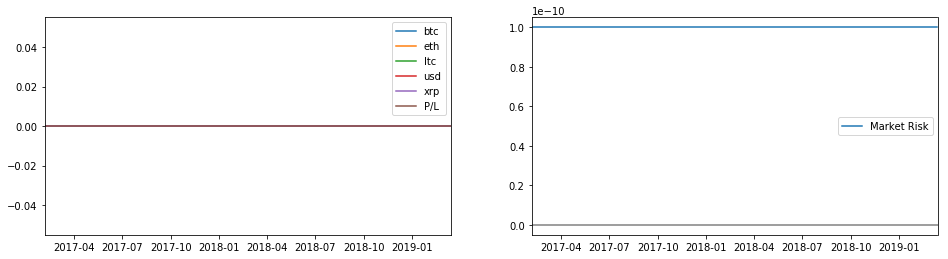

Return on market risk:        0.0
Return on absolute positions: 0.0
Final P/L:                    0.0
Final balances:
btc    0
eth    0
ltc    0
usd    0
xrp    0
Name: 2019-03-14, dtype: int64


In [5]:
from strategy import HoldStrategy

plot_results(evaluate(HoldStrategy(), data))

(array([[-2.38521619e-02, -1.18044913e-02, -9.59818192e-03,
         3.38142122e-02],
       [ 1.05080592e-01,  2.54965297e-01, -1.98229918e-01,
         7.22622359e-02],
       [-1.60186150e+00, -1.18884601e+01,  5.38097881e+00,
         6.41404351e+00],
       [ 4.83163699e+02,  2.10563530e+03, -8.39674886e+02,
        -2.48703406e+03]]), [0, 1, 2, 3])
(array([[-1.00050211e-02, -1.32432246e-02,  8.75840369e-03,
        -1.43111403e-02],
       [-1.18185543e-01,  2.39598734e-01,  1.52575055e-01,
        -2.16943710e-01],
       [ 4.98178633e+00, -3.54801592e+00, -5.41027705e+00,
         3.25910227e+00],
       [-5.16960690e+02,  2.24318173e+02,  1.06267241e+03,
         3.78282399e+02]]), [0, 1, 3])
(array([[-1.57355013e-02,  7.92983782e-03, -6.85370160e-03,
        -1.80370379e-03],
       [ 1.88791297e-01, -1.83248756e-01, -1.69120380e-01,
         1.44245888e-01],
       [-3.92681133e-01,  4.73300932e+00,  5.22544718e+00,
        -8.68175244e-01],
       [-2.89028899e+02, -6.10308

(array([[-1.58125966e-02, -8.21188191e-03,  1.48174613e-03,
        -1.23298500e-02],
       [-2.08557803e-01, -9.14235298e-02,  1.71292286e-02,
         1.93781193e-01],
       [ 9.45745179e-01, -6.09346191e-02, -5.47896884e-01,
        -3.25805780e-01],
       [-3.61756294e+01,  1.42770085e+02,  3.75903495e+02,
         2.21119368e+01]]), [0, 1])
(array([[-1.38364835e-02,  5.31206823e-03,  4.40078056e-03,
        -1.37239789e-02],
       [-2.90437035e-01,  7.59599576e-02, -2.05661583e-02,
         1.45338602e-01],
       [ 1.17390468e+00,  1.13121725e-01, -4.84579098e-01,
        -4.48706833e-01],
       [-5.38528969e+01, -1.24958183e+02,  3.63800678e+02,
         1.39814035e+02]]), [0, 1])
(array([[-1.44984220e-02,  1.17700929e-02, -8.44935268e-04,
         2.42484841e-03],
       [-4.82571035e-01,  2.22291317e-01, -6.06533894e-02,
         2.94033134e-01],
       [ 1.76502302e+00, -4.39931499e-01, -3.51726311e-01,
        -1.01270841e+00],
       [-4.35527586e+01, -1.11757044e+02, 

(array([[ 4.72445617e-03,  1.54188517e-03,  7.27729223e-03,
        -2.57047466e-02],
       [ 3.44421922e-02,  3.34888479e-01, -5.74631686e-02,
         2.74615996e+00],
       [-6.03907825e-01,  9.01139553e-01, -1.30289384e+00,
        -3.68941418e+00],
       [ 2.13748288e+02, -2.88871906e+02,  2.62356059e+02,
        -1.79381521e+03]]), [0, 1, 2, 3])
(array([[ 2.98787095e-03, -8.03109793e-03, -1.13611694e-03,
         2.05351936e-02],
       [ 4.83812950e-01,  4.03072087e-01, -9.48992982e-01,
        -2.25793009e+00],
       [-5.98025083e-01, -1.61775804e+00,  2.78624635e+00,
         2.15786550e+00],
       [-1.23238339e+02, -1.89320868e+02,  3.37542622e+02,
         1.59730553e+03]]), [0, 1, 2])
(array([[ 3.24560130e-03, -9.77569430e-03,  1.10195142e-03,
        -5.09856953e-03],
       [ 3.20081812e-01,  2.96317458e-01,  1.04402851e+00,
         1.26266443e+00],
       [-4.18744271e-01, -1.32360787e+00, -2.94303858e+00,
        -5.79659842e-01],
       [-2.46179181e+01, -1.51539

(array([[-4.87687715e-03, -9.03570110e-03, -5.65081016e-04,
        -2.59957281e-04],
       [-1.25639590e-01, -5.60956124e-02, -7.37011589e-02,
        -4.13732716e-02],
       [ 6.28563572e-01,  1.08343632e+00,  2.01702002e-01,
         2.36400255e-01],
       [-1.31152717e+02, -3.29802892e+02,  2.20270869e+02,
        -3.06082669e+01]]), [0, 3])
(array([[-2.15087753e-02,  2.84589397e-03,  3.79396743e-03,
        -1.33673423e-02],
       [-4.99772251e-01, -1.47088328e-02,  2.50697572e-01,
        -3.12045639e-01],
       [ 2.84924953e+00, -4.00532992e-01, -6.91855993e-01,
         1.59378381e+00],
       [-5.51860131e+02,  2.27534797e+02,  1.02474906e+01,
        -5.14147936e+02]]), [0])
(array([[-5.63338500e-03,  2.86264982e-03, -1.70781365e-03,
        -7.72603982e-03],
       [-3.06816255e-01, -7.35259392e-02, -7.74769652e-02,
        -1.06468022e-01],
       [ 8.67945234e-01, -3.48222432e-01,  3.88924471e-01,
         8.38087146e-01],
       [-4.58144268e+01,  2.39447946e+02,  1.

(array([[-4.16870331e-04,  5.83719802e-05, -7.01297405e-04,
         1.29240960e-03],
       [-1.50790301e-02, -1.74873064e-02, -8.50010427e-05,
        -2.41805374e-03],
       [ 2.96110225e-02,  1.41527306e-01,  1.51872245e-01,
         2.65022115e-03],
       [-3.02332222e+00, -8.71129993e+00, -1.77128700e+00,
         2.41510034e+00]]), [0, 1, 2, 3])
(array([[ 8.01071254e-04,  1.18390346e-04, -8.46677183e-04,
        -1.09392753e-03],
       [ 3.52378351e-02, -3.78314344e-03,  3.09095705e-02,
        -2.11651827e-02],
       [-2.94415590e-01,  1.45161197e-01, -1.31416788e-01,
         1.56040137e-01],
       [ 1.21981320e+01, -4.81001476e+00,  8.95942703e+00,
        -1.04679548e+01]]), [0, 1, 2, 3])
(array([[-6.24245547e-04, -2.91764927e-04,  4.94760206e-04,
         1.35146403e-03],
       [-2.22224455e-02, -2.65285684e-02,  3.21003666e-02,
        -1.14878393e-02],
       [ 1.30032923e-01,  2.97445259e-01, -2.04846287e-01,
         9.83136365e-04],
       [-5.28184882e+00, -1.19

(array([[ 2.31085941e-03,  4.61272741e-03,  2.51243514e-03,
        -9.69767103e-04],
       [ 9.23531983e-02,  9.40531961e-02,  4.45897596e-02,
         2.32220607e-01],
       [-2.09357834e-01, -1.92263429e-01, -1.49566612e-01,
        -8.51199176e-02],
       [-2.22811425e+00,  1.34881392e+01,  4.24180309e+01,
        -1.30070234e+02]]), [0, 1, 2])
(array([[-4.46998632e-03,  1.08447267e-03,  2.91937878e-03,
         4.00623879e-04],
       [-1.09468505e-01,  6.24087016e-02,  9.15793072e-02,
        -1.98965361e-01],
       [ 2.99102377e-01, -5.46520730e-02, -5.58465518e-02,
         1.97678671e-01],
       [-2.62375305e+01, -3.91269346e+01, -6.06296089e-01,
         9.42820178e+01]]), [0, 1])
(array([[-4.44018442e-03, -2.17274305e-03,  1.21896296e-03,
         1.76122867e-03],
       [-1.44564534e-01, -7.20077674e-02,  1.30729392e-01,
        -4.61707089e-02],
       [ 3.59606015e-01,  4.53220716e-02, -7.95093465e-02,
         1.09240431e-01],
       [-6.31235768e+00,  2.60310015e+0

(array([[ 3.39589764e-03, -2.56729508e-03,  4.50613876e-03,
         2.10820150e-03],
       [-2.33946630e-02, -7.31004803e-03, -2.71100658e-01,
         6.37588312e-02],
       [ 7.39407039e-01, -7.38243760e-01,  6.27814676e-01,
        -3.02910654e-01],
       [-2.87445517e+02,  1.85018620e+02,  6.94061619e+00,
        -2.08915942e+01]]), [0, 1, 2, 3])
(array([[ 5.55336758e-04, -1.88845777e-03, -4.64189528e-03,
         2.06443651e-03],
       [-4.28315538e-02, -2.11365229e-01,  1.09382389e-01,
        -4.69258659e-03],
       [-5.12598981e-02, -5.24112196e-01, -4.30332817e-01,
         1.28340582e+00],
       [-4.28585830e+01,  3.50104642e+02,  8.14172467e+01,
        -3.25941329e+02]]), [0])
(array([[-6.62536285e-04, -1.75663388e-03, -4.79797264e-03,
        -1.31846732e-03],
       [ 7.32846973e-02,  1.39631886e-01, -4.76712755e-02,
        -2.03397878e-01],
       [ 1.97155961e-01, -5.02823806e-01, -5.62345197e-01,
        -1.06304445e+00],
       [ 4.09435002e+01, -1.28627531e+0

(array([[ 6.15157753e-03,  2.33216331e-03, -4.32150673e-04,
        -2.51272722e-03],
       [ 1.87212548e-01,  2.76100361e-01,  1.09567320e-01,
         7.56000369e-02],
       [-1.59396102e+00,  4.10600843e-01, -8.19177549e-01,
         2.18883889e-02],
       [ 1.64012807e+02, -2.21573139e+02,  1.09084253e+02,
        -5.73616151e+01]]), [0, 1, 2, 3])
(array([[-4.20482628e-03, -5.07750604e-03, -1.07921897e-03,
         1.74423329e-03],
       [-2.19072433e-01, -1.90197949e-01,  2.35453477e-01,
        -1.30736249e-01],
       [-5.62282184e-01,  2.15028160e+00,  1.26607972e+00,
        -8.46916128e-02],
       [ 2.36373532e+02, -2.74856324e+02, -3.26547133e+02,
         9.33434900e+01]]), [0, 1, 2, 3])
(array([[-6.25437104e-03, -3.47598051e-03,  8.42844735e-03,
        -6.76446990e-04],
       [-1.52722593e-01, -1.39624345e-01,  9.46383580e-01,
        -2.53028149e-01],
       [ 2.17663382e+00, -3.11743838e+00,  7.25946007e+00,
        -1.23005145e+00],
       [-2.88097887e+02,  6.70

(array([[-1.37558763e-02, -5.47570482e-03, -7.72423957e-03,
         1.87250190e-02],
       [-1.09211164e-01, -1.64474012e-01,  6.04243730e-02,
         1.30592305e-01],
       [-1.72259212e+00,  4.44065283e-01, -9.70615585e-01,
         2.85515890e+00],
       [ 6.06936571e+02,  4.54024492e+01,  1.94188248e+02,
        -8.09373893e+02]]), [0, 1, 2, 3])
(array([[ 2.06946829e-02, -1.74467753e-02, -4.68439669e-03,
        -1.98089842e-02],
       [ 1.86136943e-01, -2.46030903e-01,  1.94052159e-02,
        -5.54648886e-02],
       [ 3.39566888e+00, -1.79692269e+00, -1.73236163e+00,
        -2.98128580e+00],
       [-1.04081786e+03,  7.62858416e+02,  4.72145425e+02,
         8.81644234e+02]]), [0, 1, 2, 3])
(array([[-5.68999538e-05, -5.02068791e-03,  1.70907566e-02,
         2.02370454e-02],
       [-6.75897929e-02, -1.28025308e-01,  3.14935483e-02,
         1.78450157e-01],
       [ 7.73384723e-01,  1.85532251e-01,  2.56934017e+00,
         3.89404283e+00],
       [-7.58166026e+01,  4.40

(array([[ 1.92571516e-03,  1.31917170e-03, -5.91213656e-03,
         3.84397828e-03],
       [-8.47695429e-02,  2.39197561e-01,  5.19484650e-01,
        -5.56108984e-01],
       [ 1.66109034e+00, -1.71127437e+00, -2.62800189e+00,
         3.57366732e+00],
       [-5.04018950e+02,  2.61745956e+02, -3.90659396e+02,
         3.21579315e+02]]), [0, 1])
(array([[ 1.99368592e-04, -2.36244560e-03, -3.31524272e-03,
         4.87407053e-03],
       [-2.49290581e-02,  5.44021429e-01, -2.47486441e-02,
        -4.43696218e-01],
       [-1.47496469e+00, -2.54707256e+00,  2.30902536e-01,
         2.98880997e+00],
       [ 8.68395883e+02, -3.50707940e+02, -1.16405461e+01,
         1.73264571e+02]]), [0, 3])
(array([[ 3.86200806e-03, -6.11473830e-04, -2.86462225e-03,
         9.48799299e-04],
       [ 7.43909269e-02, -2.13995449e-01,  2.84360518e-01,
        -3.63877518e-01],
       [ 1.31471999e+00,  2.17400135e+00, -7.01497386e-01,
         8.60924292e-01],
       [-7.32203224e+02, -5.08480203e+02, 

(array([[-2.14061271e-03,  8.98373609e-03, -3.89676013e-03,
        -1.70107029e-03],
       [ 1.41977073e-01,  9.60352920e-01,  2.15866582e-01,
        -4.06346732e-01],
       [-9.45355952e-01, -1.82635912e+00,  1.63139040e-01,
         1.11487035e+00],
       [-2.67737231e+00, -1.08491400e+03, -3.24952538e+02,
         4.85306995e+02]]), [0, 1, 2, 3])
(array([[-2.24421564e-03, -4.68717322e-03, -2.62846816e-03,
         8.63005906e-03],
       [ 5.72200970e-01, -5.33678642e-01,  2.09619359e-01,
         1.09975575e+00],
       [-2.60963069e+00,  1.67387063e+00,  2.05385148e-01,
        -2.51002118e+00],
       [-3.61676473e+02,  4.40962451e+02, -2.86122471e+02,
        -1.20163458e+03]]), [0, 1, 2, 3])
(array([[ 4.36601215e-03, -1.36807145e-03, -3.81410971e-03,
         6.49489466e-03],
       [-5.62697284e-01, -3.64026874e-01, -5.77523234e-02,
         1.05957455e+00],
       [ 3.19955571e+00,  1.84287437e+00,  1.04858305e+00,
        -3.11120329e+00],
       [ 2.55540524e+02,  1.57

(array([[ 1.24773913e-02, -6.81762506e-03, -1.01597015e-02,
         1.43161637e-02],
       [-2.38050618e+00,  1.17289777e+00, -1.22316783e+00,
        -1.41038309e-03],
       [ 7.95827482e+00, -9.99144258e-01,  2.50210207e+00,
         2.27670152e-02],
       [ 4.48601741e+02, -1.65575702e+02,  2.03418000e+02,
         1.03799672e+02]]), [0, 1, 2, 3])
(array([[-1.52443410e-02,  1.31789821e-02,  1.49420570e-03,
         1.11546572e-02],
       [ 2.99615145e+00, -9.28807574e-01,  2.11744530e+00,
         1.44649960e+00],
       [-8.58492111e+00, -3.68403270e-01, -2.76777394e+00,
        -1.98577824e+00],
       [-5.38388780e+02,  9.80644755e+01, -3.19351937e+02,
        -1.04066079e+02]]), [0, 1, 2, 3])
(array([[ 5.50747778e-03, -2.21136338e-02,  6.06910690e-03,
         1.08573665e-03],
       [ 4.01955051e+00,  2.19197214e+00,  7.78124545e-01,
        -5.90581236e-01],
       [-8.39292355e+00, -5.03783571e+00,  1.99101808e+00,
         2.49517331e-01],
       [-5.78668062e+02, -3.91

(array([[-3.20292096e-03,  3.52038185e-03,  1.16469421e-02,
         1.57892997e-02],
       [-9.19069643e-01,  2.77842060e-02, -5.60276949e-01,
        -5.13809521e-02],
       [ 7.61978075e-01,  2.17385444e+00,  2.80576434e+00,
         3.48377854e+00],
       [ 2.61752153e+02, -1.19514380e+02, -1.10092778e+02,
        -4.14595296e+02]]), [0, 1])
(array([[ 5.69506388e-03,  1.23546945e-03,  5.01832956e-03,
        -1.13337916e-02],
       [ 1.23817672e+00,  1.86003055e-01, -6.19365939e-01,
         3.95614166e-01],
       [-3.89656070e-01,  1.22296980e+00,  2.79991834e+00,
        -2.65022462e+00],
       [-4.19821050e+02, -1.43869976e+02,  4.19067221e+01,
         1.86548656e+02]]), [0, 1, 2, 3])
(array([[ 2.84380252e-03, -2.42435980e-03, -1.25896430e-02,
         2.42627836e-03],
       [ 1.57710996e+00, -1.69393119e-02,  8.50391208e-01,
         9.14803939e-02],
       [-8.05700170e-01, -2.31890037e+00, -3.26426506e+00,
         6.88810493e-01],
       [-5.02075746e+02,  1.60936006

(array([[-2.17537338e-03, -2.55487598e-02,  1.65147976e-02,
         8.28255432e-05],
       [-3.50220422e-01, -1.51430913e-01,  2.01919514e-01,
        -5.61361945e-02],
       [ 1.45999276e+00,  7.48674738e-01, -7.70236357e-02,
        -2.20767013e-01],
       [-1.36588503e+01, -1.38470419e+02, -7.94133628e+01,
        -1.72822114e+02]]), [0, 1, 2, 3])
(array([[-3.23731522e-02,  2.28639791e-02, -7.00957808e-03,
         5.62507411e-03],
       [ 1.70887455e-01,  3.29653144e-01, -2.45791494e-01,
        -8.79820477e-02],
       [-7.59569013e-01, -1.40771643e+00,  2.05387643e-01,
         7.01896463e-01],
       [-1.28910311e+02,  9.43558597e+01,  9.63850142e+01,
         1.43153814e+02]]), [0, 1, 2, 3])
(array([[ 1.96071682e-02, -1.51429657e-02, -1.88315453e-02,
         5.31286444e-02],
       [-4.04356178e-01, -5.03118137e-02, -3.81679363e-02,
         1.74176880e-01],
       [ 1.18266650e+00, -4.26630093e-01,  8.00267705e-01,
        -8.78002784e-01],
       [ 1.79836565e+02,  6.67

(array([[ 3.17663396e-02, -1.67162002e-02,  2.77889367e-03,
         9.95426760e-03],
       [-8.56555441e-01,  4.71425807e-01, -3.45682400e-01,
         1.19019629e-01],
       [ 1.28801476e+00,  9.11174621e-01,  5.16482411e-01,
        -4.46192929e-01],
       [ 4.65856981e+02, -8.50394707e+02,  3.31234232e+02,
         1.00580641e+02]]), [0, 1, 2, 3])
(array([[ 4.27106414e-03, -2.57016596e-02,  1.81766677e-02,
         2.78528412e-02],
       [-3.66209623e-01,  6.75358707e-01, -8.61376389e-01,
        -6.13687451e-01],
       [ 2.51604854e+00, -1.16158550e+00,  7.40390845e-01,
         7.61316545e-01],
       [-3.87123401e+02, -2.51900531e+02,  7.77561440e+02,
         4.97119679e+02]]), [0, 1, 2])
(array([[-6.07273303e-03, -2.21134819e-02,  4.79774484e-03,
         8.25513326e-03],
       [ 1.20194912e-01,  8.21925011e-01,  3.50227578e-01,
        -2.37075505e-01],
       [ 9.18798952e-01, -2.32585548e+00, -2.42598713e+00,
         3.53053168e+00],
       [-2.79912256e+02, -1.92266

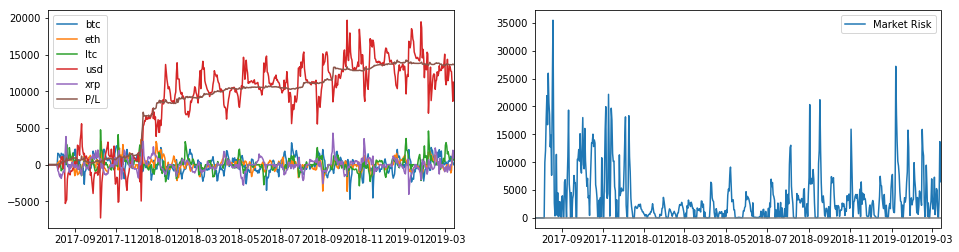

Return on market risk:        0.0061571081087147626
Return on absolute positions: 0.009417057465660714
Final P/L:                    13656.209926784102
Final balances:
btc        0.000000
eth        6.133498
ltc       10.319837
usd    11240.401081
xrp     2908.591944
Name: 2019-03-14, dtype: float64


In [9]:
from strategy import MovingAverage
from numpy_ringbuffer import RingBuffer
from math import log1p, sqrt
from johansen.johansen import Johansen

class StatArb(Strategy):
    def __init__(self, correlation_window_size, movement_half_life, size, min_edge = 0, max_edge = 1e100, correlation_subsampling = 1):
        '''edges are expressed in std deviations of the currency price
        size is $ per std dev. of edge'''
        self.prev_prices = None
        self.moving_prices_history = None
        self.correlation_window_size = correlation_window_size
        self.min_edge = min_edge
        self.max_edge = max_edge
        self.size = size
        self.correlation_subsampling = correlation_subsampling
        self.moving_prices = MovingAverage(movement_half_life)
        self.moving_volumes = MovingAverage(movement_half_life)
        self.pca = PCA(n_components=1)
        self.scaler = StandardScaler()
        
    def desired_balance_value(self, edge):
        '''Returns (expressed in USD) the desired balance for a currency at the given edge from fair'''
        if abs(edge) < self.min_edge:
            return 0
        if abs(edge) >= self.max_edge:
            return 0
        return edge * self.size
        
    def step(self, balances, prices, volumes): 
        '''Calculates fair movements by averaging correlated movements between all pairs, weighted by log-volume
        Concretely:
        fair_btc_movement =
            (btc_movment * v_btc
             + eth_movement * v_eth * stddev_btc/stddev_eth
             + ltc_movement * v_ltc * stddev_btc/stddev_ltc
             + xrp_movement * v_xrp * stddev_btc/stddev_xrp
            ) / v_total
        
        TODO: weight also by cointegration factor
        '''
        if self.moving_prices_history is None:
            self.moving_prices_history = RingBuffer(self.correlation_window_size, dtype=(np.float, len(prices.index)))
        
        self.moving_prices.step(prices)
        self.moving_volumes.step(volumes)

        if not self.moving_prices.ready:
            return {}
        
        self.moving_prices_history.append(self.moving_prices.value)
        
        if len(self.moving_prices_history) < self.correlation_window_size:
            return {}
        
        df = pd.DataFrame(np.array(self.moving_prices_history), columns = prices.index)
        
#         johansen = Johansen(df.values, model=2, significance_level=0)
        
# #         eigenvectors, r = 
#         print(johansen.johansen())
        
#         # subsampling
#         df = df.groupby(np.arange(len(df)) // self.correlation_subsampling).mean()
        
        # compute fairs, edges
        stddevs = df.std()
        corr = df.corr()
        deltas = prices - df.mean()
        predicted_deltas = (deltas * corr).mul(stddevs, axis=0).div(stddevs, axis=1)
        log_volumes = self.moving_volumes.value.apply(log1p)
        fair_deltas = (predicted_deltas * log_volumes).sum(axis=1) / log_volumes.sum()
        edges = (deltas - fair_deltas) / stddevs
        
        # turn fairs into orders
        orders = {}
        for (pair, edge) in edges.items():
            currency = pair.partition('_')[0]
            orders[pair] = self.desired_balance_value(edges[pair]) / prices[pair] - balances[currency]
            
        return orders

plot_results(evaluate(StatArb(correlation_window_size = 16, movement_half_life = 1, size = 1000, min_edge = 0.25), tail_data(data, 600)))

In [7]:
plot_results(evaluate(StatArb(correlation_window_size = 32, movement_half_life = 1, size = 1000, min_edge = 0.25), data_15min))

NameError: name 'StatArb' is not defined

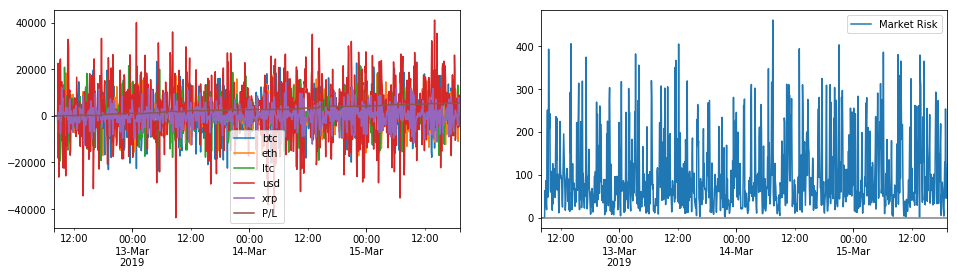

Return on market risk:        0.05578300821204998
Return on absolute positions: 0.00033357709624510617
Final P/L:                    5587.255701125241
Final balances:
btc       0.119047
eth      -4.967047
ltc     -66.450250
usd    8261.515556
xrp    4645.940941
Name: 2019-03-15 19:10:00, dtype: float64


In [81]:
plot_results(evaluate(StatArb(correlation_window_size = 4, movement_half_life = 8, size = 1000, min_edge = 0.25), tail_data(data_5min, 1000)))

In [169]:
plot_results(evaluate(StatArb(correlation_window_size = 5, movement_half_life = 1, size = 1000, min_edge = 0), data_min))

KeyboardInterrupt: 

Trying window_size: 4 and half_life: 36.15977708580905
  RoR: 0.002265728051529942
Trying window_size: 4 and half_life: 66.02408083773594
  RoR: 0.004538185483346184
Trying window_size: 5 and half_life: 31.130653353004817
  RoR: 0.002208708150815142
Trying window_size: 5 and half_life: 36.80001863887392
  RoR: 0.005856131630058562
Trying window_size: 5 and half_life: 67.71885057077685
  RoR: 0.003523806206202591
Trying window_size: 5 and half_life: 33.89336812886329
  RoR: 0.003758599102393558
Trying window_size: 4 and half_life: 25.284324835438063
  RoR: -0.0018621198902417345
Trying window_size: 4 and half_life: 22.627660525008867
  RoR: -0.002149229163434422
Trying window_size: 6 and half_life: 54.073952580270024
  RoR: 0.0030357904333170537
Trying window_size: 4 and half_life: 27.97719857122574
  RoR: 0.0007806512519817738
Trying window_size: 4 and half_life: 91.03235792245862
  RoR: 0.0021735157546419227
Trying window_size: 4 and half_life: 45.41933194496844
  RoR: 0.0028860364783

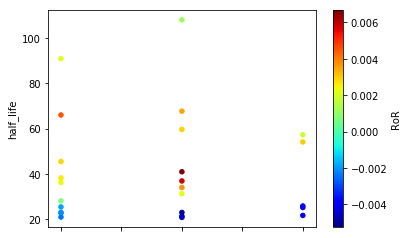

In [74]:
import random

def find_best_window_sizes(data, n):
    points = []
    best = None
    best_ror = 0
    for _ in range(n):
        movement_half_life = random.expovariate(1) * 20 + 20
#         window_ratio = random.uniform(1, 10)
#         window_size = max(3, int(movement_half_life * window_ratio))
#         movement_half_life = 2
        window_size = int(random.uniform(4, 7))
#         window_size = 4
        print('Trying window_size: {0} and half_life: {1}'.format(window_size, movement_half_life))
        results = evaluate(StatArb(window_size, movement_half_life, size=1000, min_edge=0.25), data)
        ror = return_on_risk(results)
        print('  RoR: {0}'.format(ror))
        point = { 'window_size': window_size, 'half_life': movement_half_life, 'RoR': ror }
        points.append(point)
        if ror > best_ror:
            best = point
            best_ror = ror
    print('Best found:')
    print(best)
    pd.DataFrame(points).plot.scatter('window_size', 'half_life', c='RoR', colormap='jet')
    
find_best_window_sizes(tail_data(data_5min, 600), 25)